# MCMC with `corrprior.CorrectPrior`
In this notebook, I demonstrate how you acn use MCMC with `corrprior.CorrectPrior` object

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

In [3]:
m_nmf = Models.NMF(burst=True, emulator=True)
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # fburst
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst 
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# generate fake observations
that galaxy properties not in the center of our prior

In [4]:
z_obs = 0.1

logssfr = -11
while np.abs(logssfr + 11) < 1: 
    _theta = prior.sample()
    logssfr = np.log10(m_nmf.avgSFR(prior.transform(_theta), zred=z_obs, dt=1)) - _theta[0]
print(logssfr)
theta_obs = prior.transform(_theta)
wave_obs, flux_obs = m_nmf.sed(theta_obs, zred=z_obs, vdisp=0, wavelength=np.linspace(3e3, 1e4, 1000))

[-12.07053668]


# define `corrprior.CorrectPrior` object
to impose uniform priors on galaxy properties

In [5]:
CP_kde = Corrprior.CorrectPrior(
    m_nmf, 
    prior, 
    zred=z_obs,
    props=['logavgssfr_1gyr', 'z_mw'], 
    range=[(-13, -9), (2e-3, 3e-2)],
    Nprior=100000, 
    method='kde',
    bandwidth=0.1,
    debug=True
)

... calculating log avg sSFR_1Gyr
... calculating mass-weighted Z
... fitting prior(derived prop)
... fitting pdf using kde


validate `corrprior.CorrectPrior`

In [6]:
theta_deriv_obs = CP_kde._get_properties(theta_obs)[0]

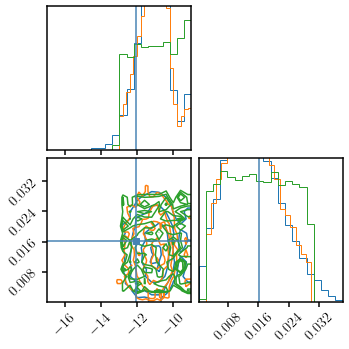

In [7]:
fig = CP_kde.validate(truths=theta_deriv_obs)

# running MCMC without `corrprior.CorrectPrior` 
but correcting the prior using importance weights

In [8]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior)

In [9]:
mcmc_chain = desi_mcmc.run(
    wave_obs=wave_obs, 
    flux_obs=flux_obs, 
    flux_ivar_obs=np.ones(wave_obs.shape),
    zred=z_obs, 
    vdisp=0.,
    sampler='zeus',
    theta_start=prior.untransform(theta_obs),
    nwalkers=30, 
    burnin=0,
    opt_maxiter=2000,
    niter=1500, 
    debug=True)

Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/1500 [00:00<?, ?it/s]

--- initializing the walkers ---
initial theta = [11.925376395986058, 0.19432851870970813, 0.35945369826549123, 0.9546090509410596, 0.13388526389760802, 12.00362902541631, 0.004630740643523121, 0.003918028935006674, 0.6881610553209975, 1.6827485878908468, -1.2748575032334168]
log Posterior(theta0) = 0.000000
--- running MCMC ---


Sampling progress : 100%|██████████| 1500/1500 [20:56<00:00,  1.19it/s]

bestfit theta = [11.924858954362659, 0.8071342999692258, 0.12351993144830228, 0.0031148280792738458, 0.06623094050319805, 0.13383609018653003, 11.988350880756295, 0.004637157366068741, 0.003913974884542191, 0.6875318133108476, 1.6816386055246875, -1.2765973217382713]
log Posterior = -0.038186
Model.sed: redshift = 0.100000
Model.sed: ssp lum [4.88302308e+00 5.47978139e+00 5.75184335e+00 ... 1.62512892e+07
 1.60468331e+07 1.59826147e+07]


In [10]:
flat_chain = desi_mcmc._flatten_chain(mcmc_chain['mcmc_chain'][200:,:,:])
w_imp = CP_kde.get_importance_weights(flat_chain, outlier=0.1)

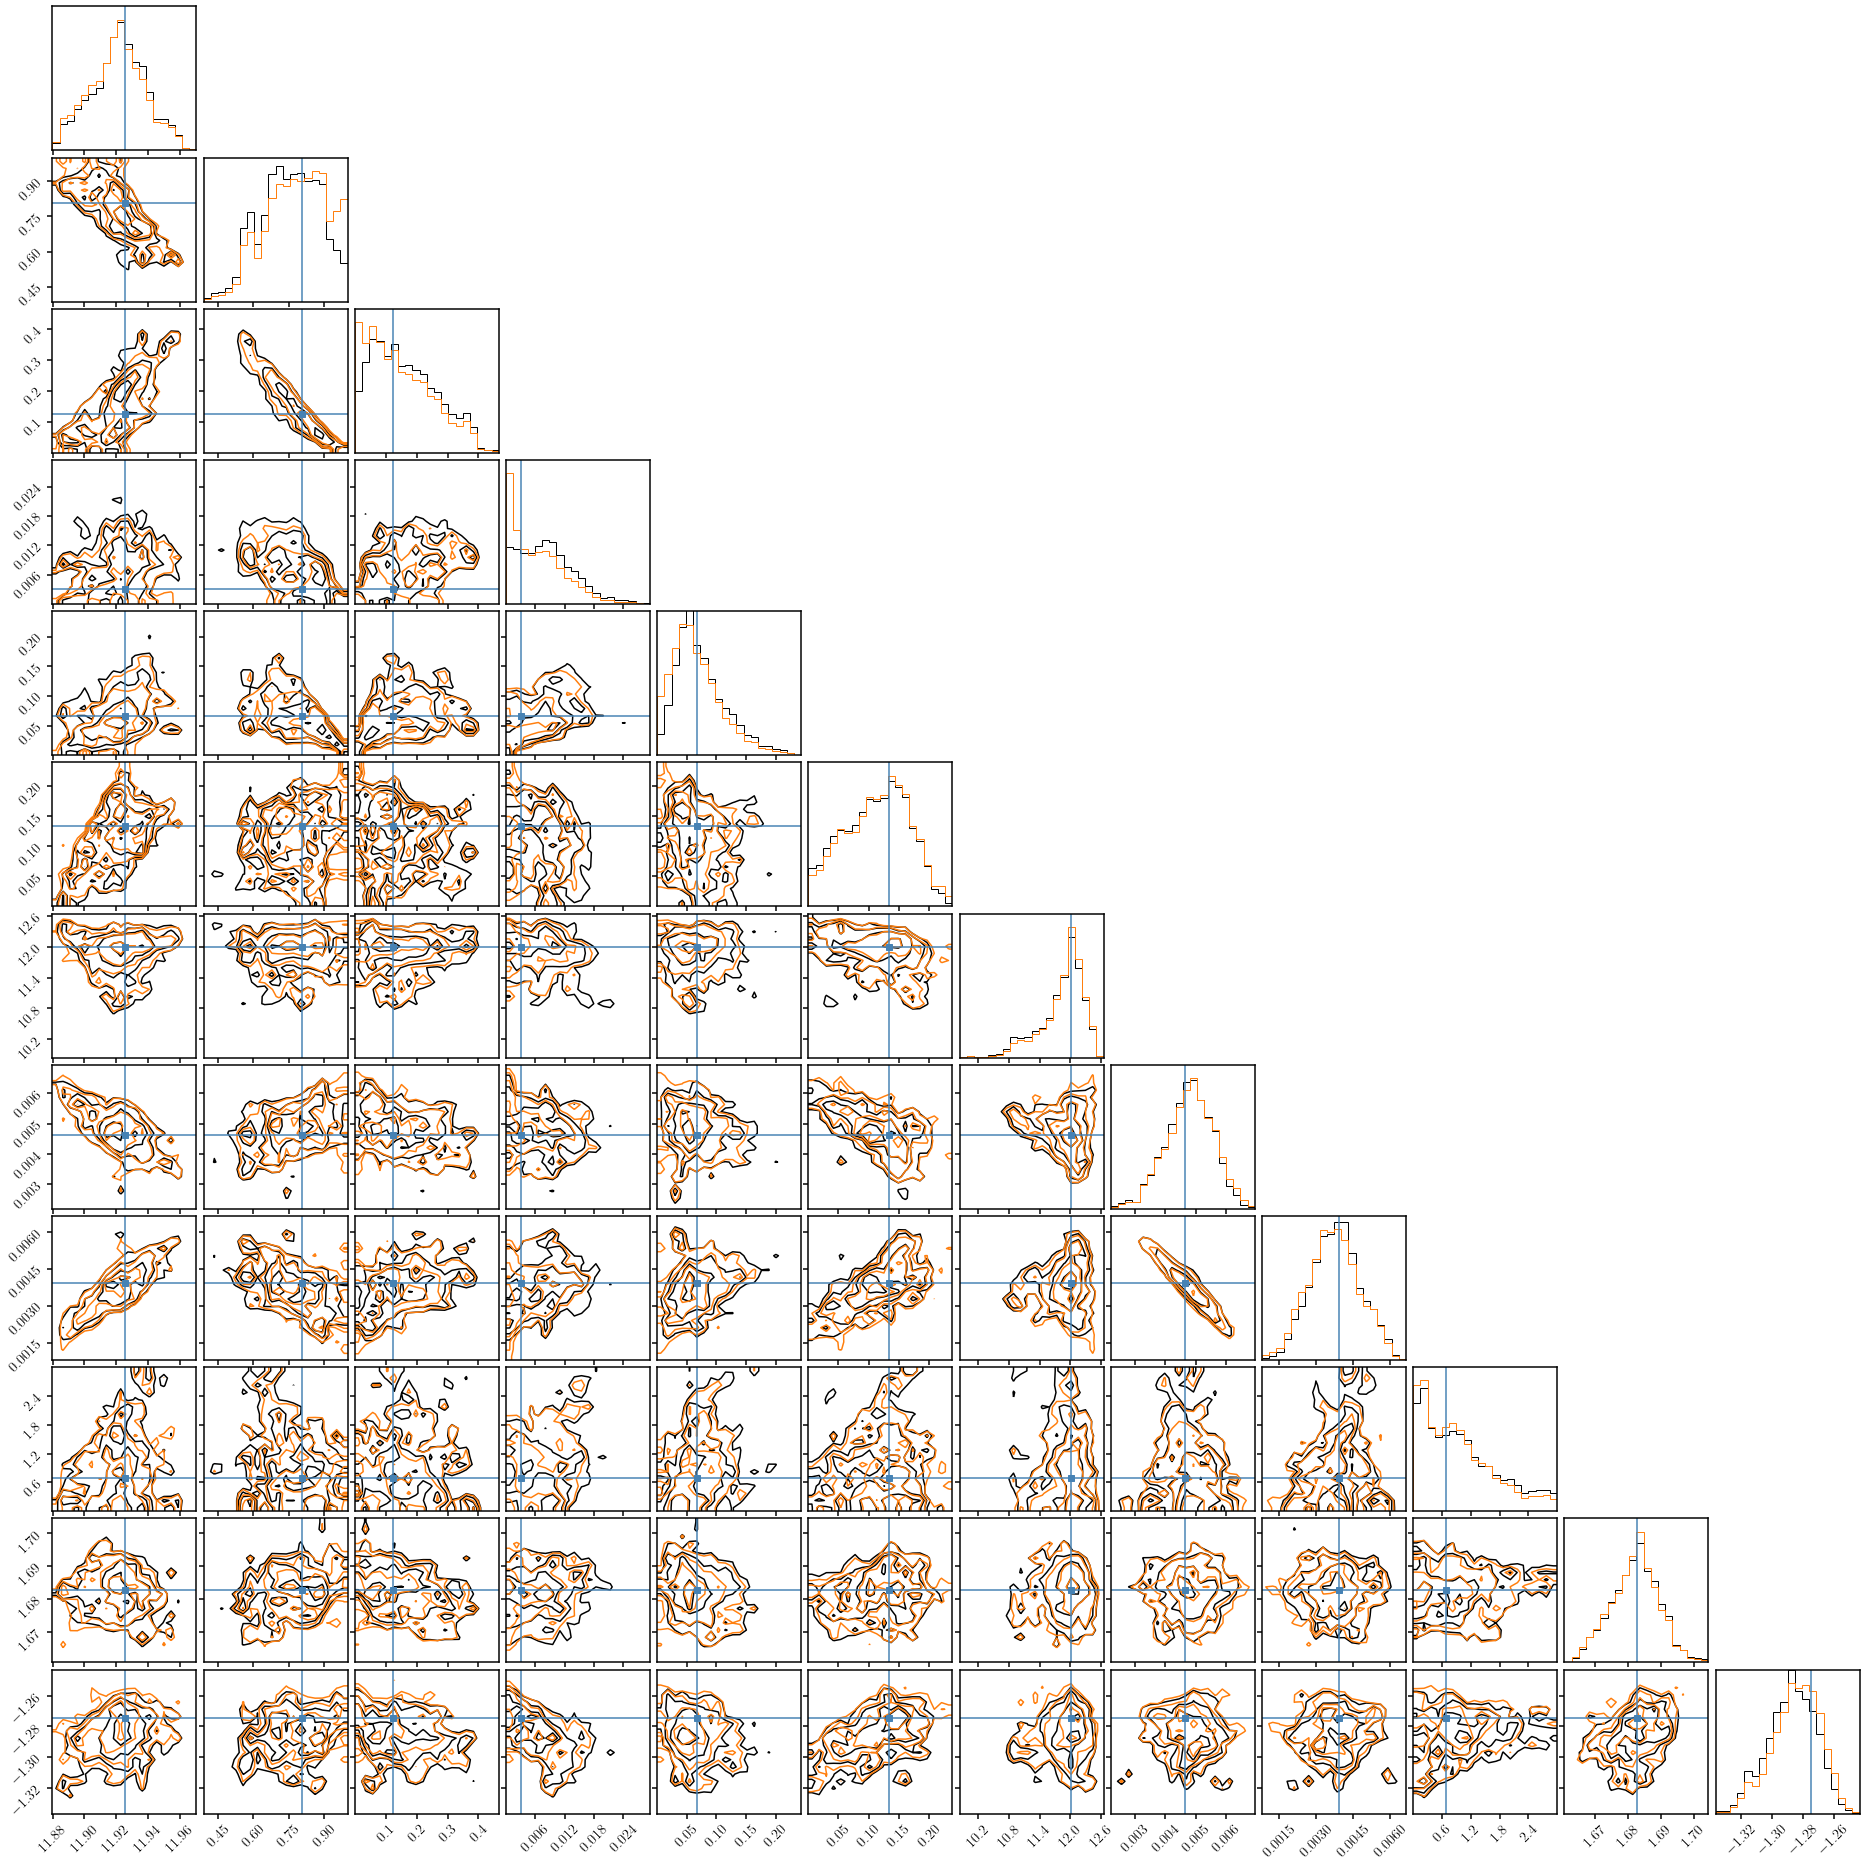

In [11]:
fig = DFM.corner(flat_chain, truths=theta_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_chain, weights=w_imp, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

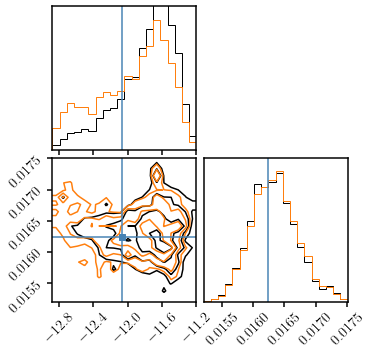

In [12]:
flat_deriv_chain = CP_kde._get_properties(flat_chain)
fig = DFM.corner(flat_deriv_chain, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_deriv_chain, weights=w_imp, truths=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

The importance weights, definitely reduce the bias, but looks a bit skewed. This might be due to numerical effects. Fortunately, we can

# run MCMC with `corrprior.CorrectPrior`
to run MCMC with CorrectPrior run on the fly

In [13]:
desi_mcmc_priorcorr = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior,
    corrprior=CP_kde)

In [14]:
mcmc_chain_priorcorr = desi_mcmc_priorcorr.run(
    wave_obs=wave_obs, 
    flux_obs=flux_obs, 
    flux_ivar_obs=np.ones(wave_obs.shape),
    zred=z_obs, 
    vdisp=0.,
    sampler='zeus',
    theta_start=prior.untransform(theta_obs),
    nwalkers=30, 
    burnin=0,
    opt_maxiter=2000,
    niter=1500, 
    debug=True)

--- initializing the walkers ---
initial theta = [11.925376395986058, 0.19432851870970813, 0.35945369826549123, 0.9546090509410596, 0.13388526389760802, 12.00362902541631, 0.004630740643523121, 0.003918028935006674, 0.6881610553209975, 1.6827485878908468, -1.2748575032334168]
log Posterior(theta0) = 2.665486


Initialising ensemble of 30 walkers...


--- running MCMC ---


Sampling progress : 100%|██████████| 1500/1500 [44:19<00:00,  1.77s/it]

bestfit theta = [11.930651358122715, 0.8184007146695669, 0.1531898938495747, 1.7495227468318925e-05, 0.02839189625339008, 0.15495565532418698, 11.991649313232372, 0.004907996121502983, 0.0036769240878927203, 0.0711880937634828, 1.6840041690666985, -1.26160876724999]
log Posterior = 3.335510
Model.sed: redshift = 0.100000
Model.sed: ssp lum [4.02940220e+00 4.31214537e+00 4.35472949e+00 ... 1.62752984e+07
 1.60720293e+07 1.60079754e+07]


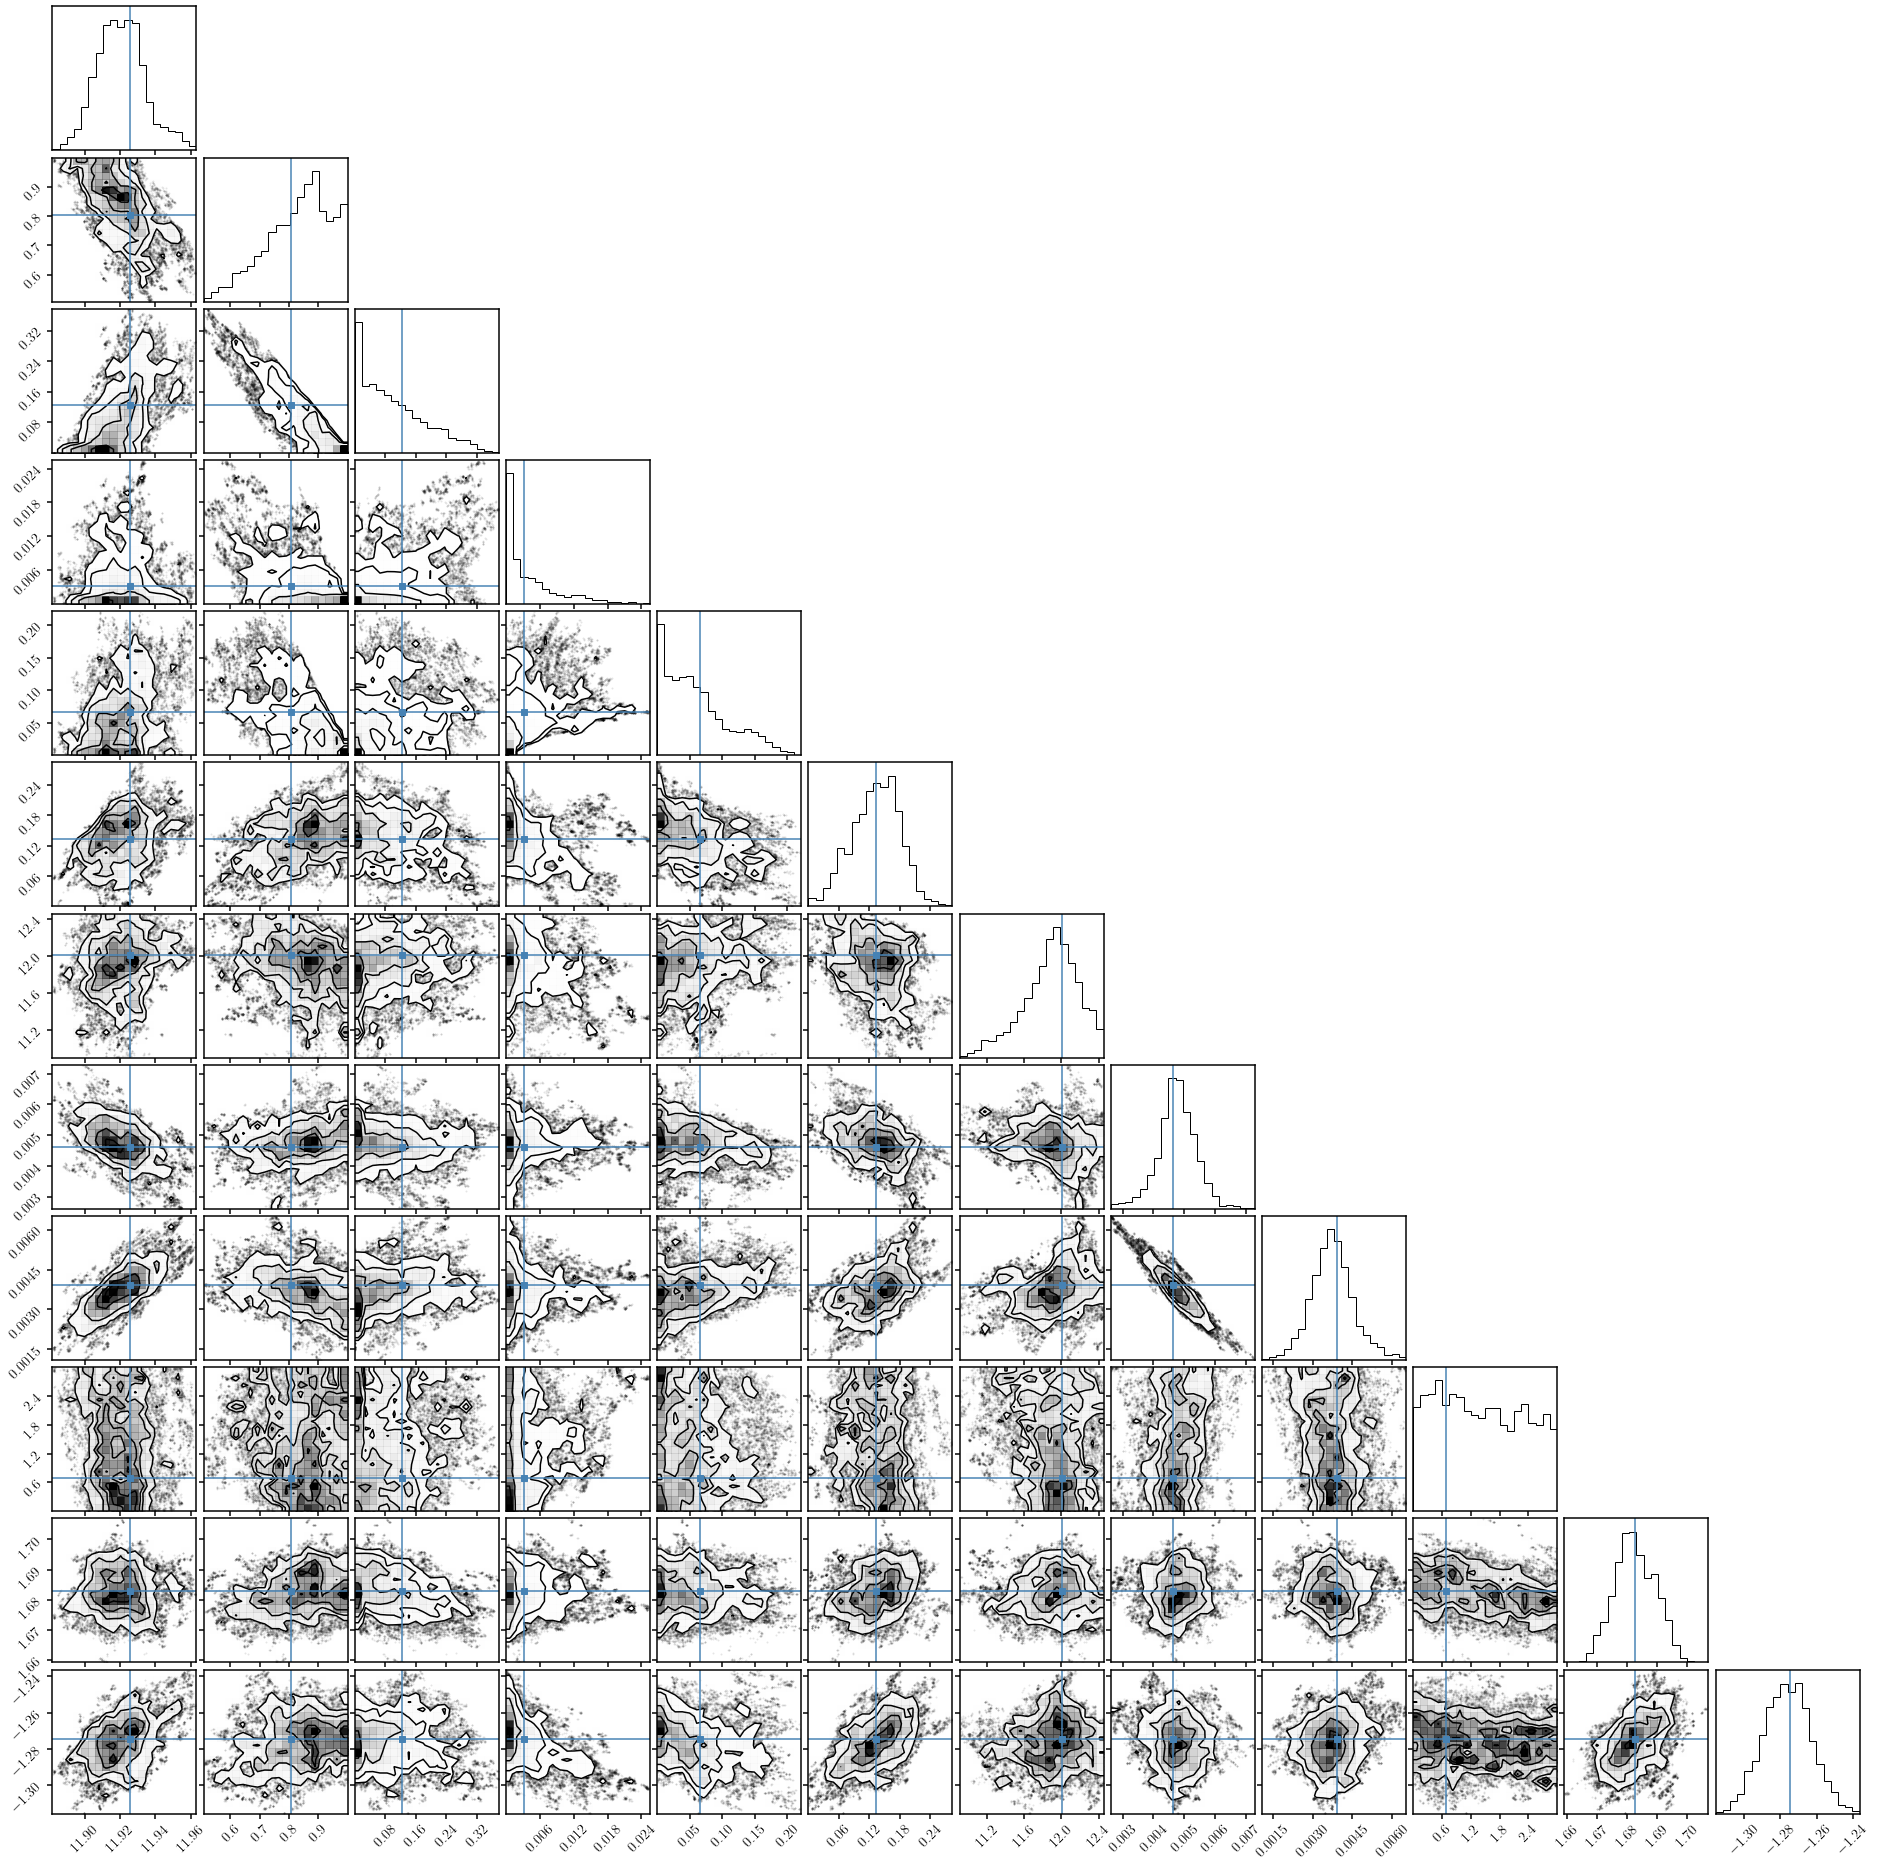

In [15]:
flat_chain_priorcorr = desi_mcmc._flatten_chain(mcmc_chain_priorcorr['mcmc_chain'][200:,:,:])
_ = DFM.corner(flat_chain_priorcorr, truths=theta_obs)

In [16]:
flat_deriv_chain_priorcorr = CP_kde._get_properties(flat_chain_priorcorr)

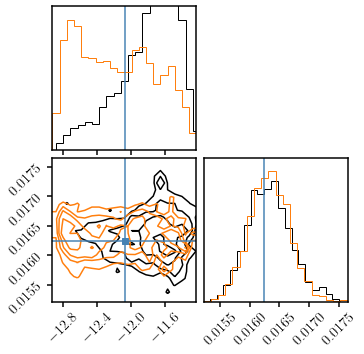

In [17]:
fig = DFM.corner(flat_deriv_chain, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_deriv_chain_priorcorr, truths=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

# Nice.